# Plot Trajectories

Plotting various trajecories to demonstrate the differences between behavior of agents.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from utilities import get_agent
from environments import OctorotorEnvSelector
from systems.pid_agent import PIDAgent
from multirotor.helpers import DataLog
from systems.long_blending import softmax

### Loading Agents

In [2]:
env_selector = OctorotorEnvSelector()

In [3]:
pid_sl_params = {'steps_u':50, 'scaling_factor':0, 'window_distance':10}
pid_sl_agent = PIDAgent()

pid_params = {'steps_u':50, 'scaling_factor':0, 'window_distance':1000}
pid_agent = PIDAgent()

In [4]:
study, blending_agent, blending_params = get_agent('blending@softmax@scaled', filepath='BlendingEnv')
blending_params['steps_u'] = 50
blending_params['bounding_rect_length']=1000
blending_params['window_distance']=10
blending_params['scaling_factor']=5

study, full_agent, full_params = get_agent('allwind')
full_params['steps_u'] = 50
full_params['bounding_rect_length']=1000
full_params['window_distance']=10

[I 2023-09-15 11:59:12,438] Using an existing study with name 'blending@softmax@scaled' instead of creating a new one.
[I 2023-09-15 11:59:13,993] Using an existing study with name 'allwind' instead of creating a new one.


In [5]:
all_agents = [pid_agent, pid_sl_agent, blending_agent, full_agent]
all_params = [pid_params, pid_sl_params, blending_params, full_params]

In [6]:
types = ["sliding", "sliding", "blending", "sliding"]

In [7]:
nasa_wp = np.asarray([ # defines a real trajectory shown in a NASA paper
    [164.0146725649829, -0.019177722744643688, 0],
    [165.6418055187678, 111.5351051245816, 0],
    [127.3337449710234, 165.73576059611514, 0],
    [-187.28170707810204, 170.33217775914818, 10],
    [-192.03130502498243, 106.30660058604553, 10],
    [115.89920266153058, 100.8644210617058, 0],
    [114.81859536317643, 26.80923518165946, 0],
    [-21.459931490011513, 32.60508110653609, 0]
])

In [8]:
# Evaluates all saved agents with their params on a wind range
def evaluate_agents(agents, params, wind_range, types):
    logs = []
    
    for agent, param, env_type in tqdm(zip(agents, params, types), total=len(agents)):
        
        env = env_selector.get_env(env_type, param, wind_range, nasa_wp)
        done = False
        state = env.reset()
        state = np.array(state, dtype=np.float32)
        log = DataLog(env.base_env.vehicle, env.base_env.ctrl,
                          other_vars=('reward',))
        while not done:
            action = agent.predict(state, deterministic=True)[0] 
            state, reward, done, info = env.step(action)
            state = np.array(state, dtype=np.float32)
            log.log(reward=reward)
        
        log.done_logging()
        logs.append(log)

    return logs

## Real Trajectory Evaluation

### 10 m/s North

In [9]:
logs = evaluate_agents(all_agents, all_params, [(0,0), (10,10), (0,0)], types)

 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 2/4 [00:15<00:14,  7.48s/it][I 2023-09-15 11:59:29,521] Using an existing study with name 'highwind' instead of creating a new one.
[I 2023-09-15 11:59:29,580] Using an existing study with name 'midwind' instead of creating a new one.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:37<00:00,  9.29s/it]


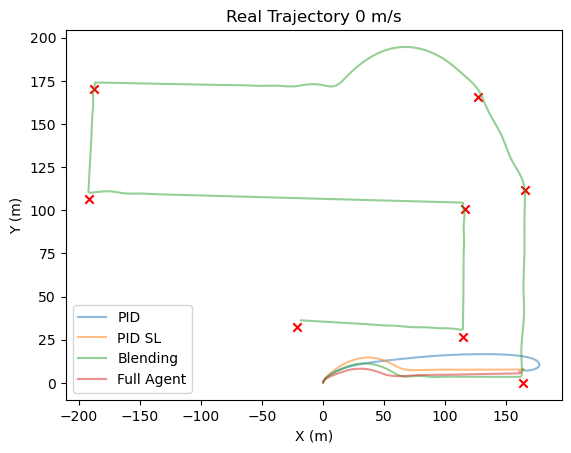

In [10]:
plt.title("Real Trajectory 0 m/s")
plt.plot(logs[0].x, logs[0].y, label='PID', alpha=0.5)
plt.plot(logs[1].x, logs[1].y, label='PID SL', alpha=0.5)
plt.plot(logs[2].x, logs[2].y, label='Blending', alpha=0.5)
plt.plot(logs[3].x, logs[3].y, label='Full Agent', alpha=0.5)
plt.scatter(nasa_wp[:,0], nasa_wp[:,1], marker='x', color="red")
plt.legend(loc='lower left')
# plt.xlim(-100, 110)
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.show()

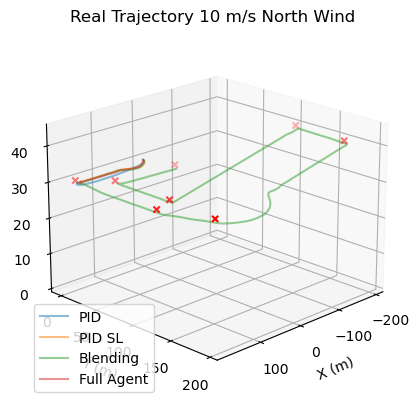

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_title("Real Trajectory 10 m/s North Wind")
ax.plot(logs[0].x, logs[0].y, logs[0].z+30, label='PID', alpha=0.5)
ax.plot(logs[1].x, logs[1].y, logs[1].z+30, label='PID SL', alpha=0.5)
ax.plot(logs[2].x, logs[2].y, logs[2].z+30, label='HRL Agent', alpha=0.5)
ax.plot(logs[3].x, logs[3].y, logs[3].z+30, label='Full Agent', alpha=0.5)
ax.scatter(nasa_wp[:,0], nasa_wp[:,1], nasa_wp[:,2]+30, marker='x', color="red")

ax.legend(loc='lower left')
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (log.z)")
ax.set_zlim(0,45)
ax.view_init(20,45)
plt.show()


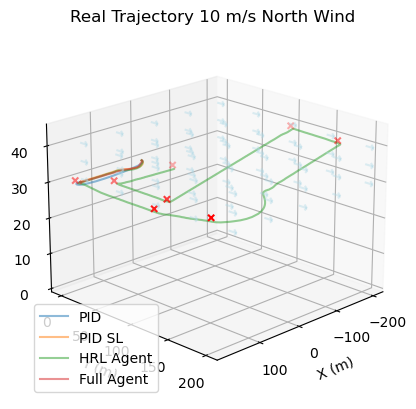

In [38]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Assuming you have defined logs, nasa_wp, and other variables previously

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_title("Real Trajectory 10 m/s North Wind")
ax.plot(logs[0].x, logs[0].y, logs[0].z + 30, label='PID', alpha=0.5)
ax.plot(logs[1].x, logs[1].y, logs[1].z + 30, label='PID SL', alpha=0.5)
ax.plot(logs[2].x, logs[2].y, logs[2].z + 30, label='HRL Agent', alpha=0.5)
ax.plot(logs[3].x, logs[3].y, logs[3].z + 30, label='Full Agent', alpha=0.5)
ax.scatter(nasa_wp[:, 0], nasa_wp[:, 1], nasa_wp[:, 2] + 30, marker='x', color="red")

# Create a grid of points to represent the wind field
x_range = np.linspace(-200, 150, 5)  # Adjust the number of points as needed
y_range = np.linspace(0, 200, 5)  # Adjust the number of points as needed
z_range = np.linspace(30, 40, 3)  # Adjust the z-range as needed

# Create a grid of points using meshgrid
X, Y, Z = np.meshgrid(x_range, y_range, z_range, indexing='ij')

# Define wind vectors at each grid point
U = np.zeros_like(X)  # Adjust the wind components as needed
V = np.ones_like(Y)
W = np.zeros_like(Z)

# Plot the wind vectors
ax.quiver(X, Y, Z, U, V, W, color='lightblue', alpha=0.4,length=10)

ax.legend(loc='lower left')
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")
ax.set_zlim(0, 45)
ax.view_init(20, 45)
plt.savefig('./figures/n_nasa.png')
plt.show()


In [13]:
np.linspace(min(logs[3].x), max(logs[3].x))

array([5.21249995e-02, 3.34980434e+00, 6.64748367e+00, 9.94516301e+00,
       1.32428423e+01, 1.65405217e+01, 1.98382010e+01, 2.31358804e+01,
       2.64335597e+01, 2.97312390e+01, 3.30289184e+01, 3.63265977e+01,
       3.96242770e+01, 4.29219564e+01, 4.62196357e+01, 4.95173150e+01,
       5.28149944e+01, 5.61126737e+01, 5.94103531e+01, 6.27080324e+01,
       6.60057117e+01, 6.93033911e+01, 7.26010704e+01, 7.58987497e+01,
       7.91964291e+01, 8.24941084e+01, 8.57917877e+01, 8.90894671e+01,
       9.23871464e+01, 9.56848258e+01, 9.89825051e+01, 1.02280184e+02,
       1.05577864e+02, 1.08875543e+02, 1.12173222e+02, 1.15470902e+02,
       1.18768581e+02, 1.22066260e+02, 1.25363940e+02, 1.28661619e+02,
       1.31959298e+02, 1.35256978e+02, 1.38554657e+02, 1.41852336e+02,
       1.45150016e+02, 1.48447695e+02, 1.51745374e+02, 1.55043054e+02,
       1.58340733e+02, 1.61638412e+02])

In [18]:
max(logs[3].x)

161.63841

### 7 m/s South

In [39]:
logs = evaluate_agents(all_agents, all_params, [(0,0), (-7,-7), (0,0)], types)

 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 2/4 [00:19<00:21, 10.68s/it][I 2023-09-15 12:10:56,026] Using an existing study with name 'highwind' instead of creating a new one.
[I 2023-09-15 12:10:56,096] Using an existing study with name 'midwind' instead of creating a new one.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:45<00:00, 11.48s/it]


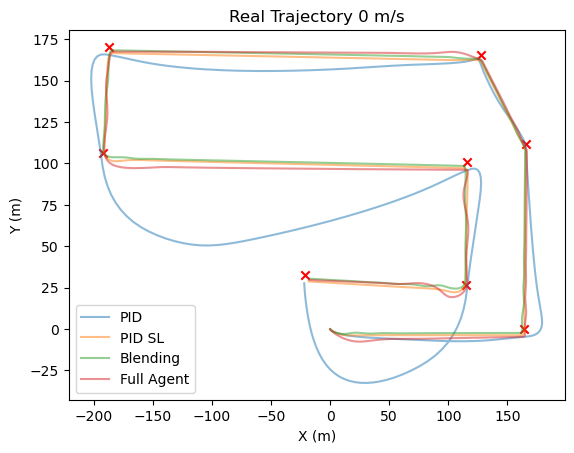

In [30]:
plt.title("Real Trajectory 0 m/s")
plt.plot(logs[0].x, logs[0].y, label='PID', alpha=0.5)
plt.plot(logs[1].x, logs[1].y, label='PID SL', alpha=0.5)
plt.plot(logs[2].x, logs[2].y, label='Blending', alpha=0.5)
plt.plot(logs[3].x, logs[3].y, label='Full Agent', alpha=0.5)
plt.scatter(nasa_wp[:,0], nasa_wp[:,1], marker='x', color="red")
plt.legend(loc='lower left')
# plt.xlim(-100, 110)
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.show()

In [35]:
len(logs[3].x)

537

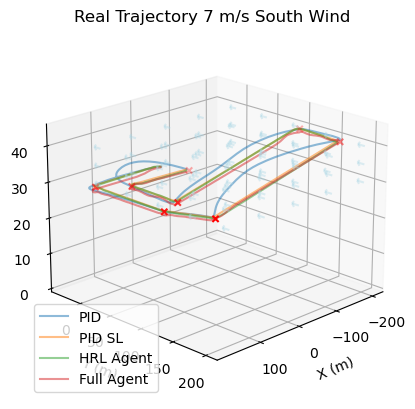

In [42]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_title("Real Trajectory 7 m/s South Wind")
ax.plot(logs[0].x, logs[0].y, logs[0].z+30, label='PID', alpha=0.5)
ax.plot(logs[1].x, logs[1].y, logs[1].z+30, label='PID SL', alpha=0.5)
ax.plot(logs[2].x, logs[2].y, logs[2].z+30, label='HRL Agent', alpha=0.5)
ax.plot(logs[3].x, logs[3].y, logs[3].z+30, label='Full Agent', alpha=0.5)
ax.scatter(nasa_wp[:,0], nasa_wp[:,1], nasa_wp[:,2]+30, marker='x', color="red")

# Create a grid of points to represent the wind field
x_range = np.linspace(-200, 150, 5)  # Adjust the number of points as needed
y_range = np.linspace(0, 200, 5)  # Adjust the number of points as needed
z_range = np.linspace(30, 40, 3)  # Adjust the z-range as needed

# Create a grid of points using meshgrid
X, Y, Z = np.meshgrid(x_range, y_range, z_range, indexing='ij')

# Define wind vectors at each grid point
U = np.zeros_like(X)  # Adjust the wind components as needed
V = -np.ones_like(Y)
W = np.zeros_like(Z)

# Plot the wind vectors
ax.quiver(X, Y, Z, U, V, W, color='lightblue', alpha=0.4,length=10)

ax.legend(loc='lower left')
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")
ax.set_zlim(0, 45)
ax.view_init(20, 45)
plt.savefig('./figures/s_nasa.png')
plt.show()
